In [4]:
ls

README.md*               calibration.ipynb*  data/              run.sh*  src/
calibrated_network.png*  checkpoints/        requirements.txt*  scores/


In [5]:
import torch
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt; plt.style.use('seaborn')

/tmp/ipykernel_196780/2623516690.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  import matplotlib.pyplot as plt; plt.style.use('seaborn')


In [68]:
dataset = 'mnist'
# dataset = 'fashion'
# dataset = 'cifar'

cen_val_scores = torch.load(f'scores/{dataset}/central_stage1_val_scores.pth', map_location=torch.device('cpu'))
cen_val_targets = torch.load(f'scores/{dataset}/central_stage1_val_targets.pth', map_location=torch.device('cpu'))
fed_val_scores = torch.load(f'scores/{dataset}/fedavg_stage1_val_scores.pth', map_location=torch.device('cpu'))
fed_val_targets = torch.load(f'scores/{dataset}/fedavg_stage1_val_targets.pth', map_location=torch.device('cpu'))
tct_val_scores = torch.load(f'scores/{dataset}/tct_stage2_val_scores.pth', map_location=torch.device('cpu'))
tct_val_targets = torch.load(f'scores/{dataset}/tct_stage2_val_targets.pth', map_location=torch.device('cpu'))

cen_test_scores = torch.load(f'scores/{dataset}/central_stage1_test_scores.pth', map_location=torch.device('cpu'))
cen_test_targets = torch.load(f'scores/{dataset}/central_stage1_test_targets.pth', map_location=torch.device('cpu'))
fed_test_scores = torch.load(f'scores/{dataset}/fedavg_stage1_test_scores.pth', map_location=torch.device('cpu'))
fed_test_targets = torch.load(f'scores/{dataset}/fedavg_stage1_test_targets.pth', map_location=torch.device('cpu'))
tct_test_scores = torch.load(f'scores/{dataset}/tct_stage2_test_scores.pth', map_location=torch.device('cpu'))
tct_test_targets = torch.load(f'scores/{dataset}/tct_stage2_test_targets.pth', map_location=torch.device('cpu'))

FileNotFoundError: [Errno 2] No such file or directory: 'scores/mnist/fedavg_stage1_val_scores.pth'

In [ ]:
cen_test_scores.shape, fed_test_scores.shape, tct_test_scores.shape

In [69]:
acc = lambda scores, targets: (scores.argmax(1) == targets).sum() / targets.size(0)

In [67]:
print('central', acc(cen_test_scores, cen_test_targets))
print('fedavg', acc(fed_test_scores, fed_test_targets))
print('tct', acc(tct_test_scores, tct_test_targets))

central tensor(0.8150)
fedavg tensor(0.3950)
tct tensor(0.3900)


In [53]:
def calc_bins(scores, targets):
    # Assign each prediction to a bin
    num_bins = 10
    bins = np.linspace(0.1, 1, num_bins)
    binned = np.digitize(scores, bins)

    # Save the accuracy, confidence and size of each bin
    bin_accs = np.zeros(num_bins)
    bin_confs = np.zeros(num_bins)
    bin_sizes = np.zeros(num_bins)

    for bin in range(num_bins):
        bin_sizes[bin] = len(scores[binned == bin])
        if bin_sizes[bin] > 0:
            bin_accs[bin] = (targets[binned==bin]).sum() / bin_sizes[bin]
            bin_confs[bin] = (scores[binned==bin]).sum() / bin_sizes[bin]

    return bins, binned, bin_accs, bin_confs, bin_sizes



In [54]:
def get_metrics(scores, targets):
    ECE = 0
    MCE = 0
    bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(scores, targets)

    for i in range(len(bins)):
        abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
        ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
        MCE = max(MCE, abs_conf_dif)

    return ECE, MCE

In [55]:
import matplotlib.patches as mpatches

def draw_reliability_graph(scores, targets):
    ECE, MCE = get_metrics(scores, targets)
    bins, _, bin_accs, _, _ = calc_bins(scores, targets)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca()

    # x/y limits
    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1)

    # x/y labels
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')

    # Create grid
    ax.set_axisbelow(True) 
    ax.grid(color='gray', linestyle='dashed')

    # Error bars
    plt.bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

    # Draw bars and identity line
    plt.bar(bins, bin_accs, width=0.1, alpha=1, edgecolor='black', color='b')
    plt.plot([0,1],[0,1], '--', color='gray', linewidth=2)

    # Equally spaced axes
    plt.gca().set_aspect('equal', adjustable='box')

    # ECE and MCE legend
    ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
    MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
    plt.legend(handles=[ECE_patch, MCE_patch])

    plt.show()

    # plt.savefig('calibrated_network.png', bbox_inches='tight')

In [56]:
def temp_scale(logits, labels, plot=True):
    temperature = torch.nn.Parameter(torch.ones(1))#.to('cuda' if torch.cuda.is_available() else 'cpu')
    # print(temperature.is_leaf)
    criterion = torch.nn.CrossEntropyLoss()

    # Removing strong_wolfe line search results in jump after 50 epochs
    optimizer = torch.optim.LBFGS([temperature], lr=0.001, max_iter=10000, line_search_fn='strong_wolfe')

    temps = []
    losses = []

    def _eval():
        loss = criterion(torch.div(logits, temperature), labels)
        loss.backward()
        temps.append(temperature.item())
        losses.append(loss.item())
        return loss


    optimizer.step(_eval)

    print('Final T_scaling factor: {:.2f}'.format(temperature.item()))

    if plot:
        plt.subplot(121)
        plt.plot(list(range(len(temps))), temps)

        plt.subplot(122)
        plt.plot(list(range(len(losses))), losses)
        plt.show()
    return temperature.detach()


Final T_scaling factor: 9.63


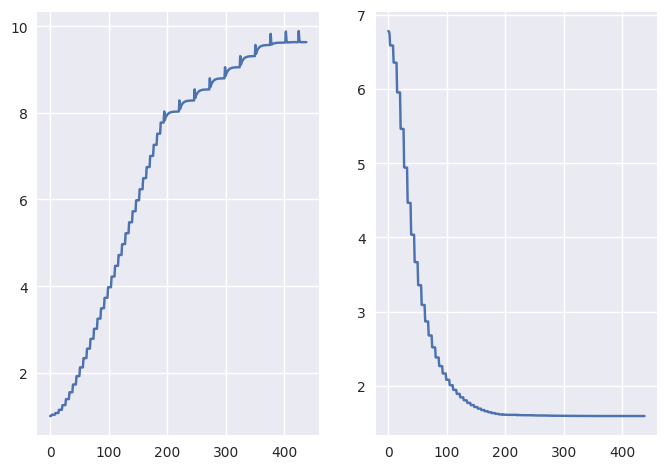

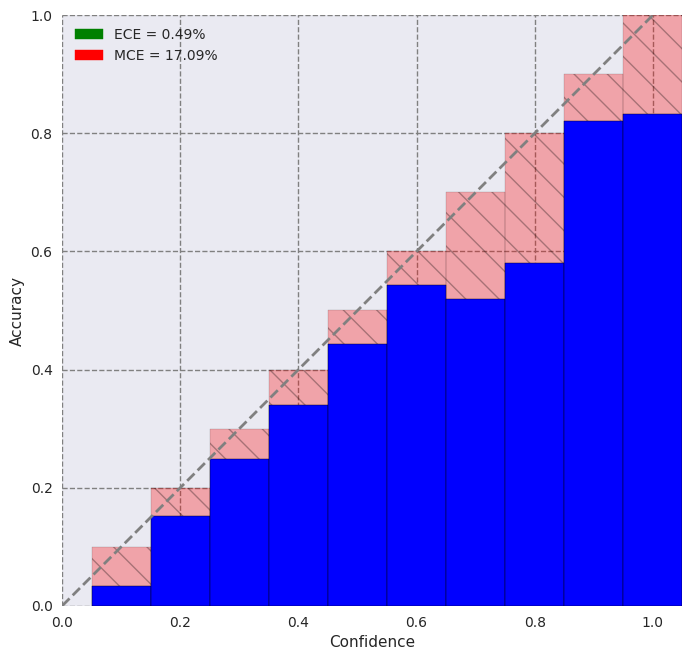

In [57]:
cen_temp = temp_scale(cen_val_scores, cen_val_targets)
draw_reliability_graph(torch.softmax(cen_test_scores / cen_temp, 1), torch.nn.functional.one_hot(cen_test_targets))
# draw_reliability_graph(torch.softmax(cen_test_scores, 1), torch.nn.functional.one_hot(cen_test_targets))

Final T_scaling factor: 5.62


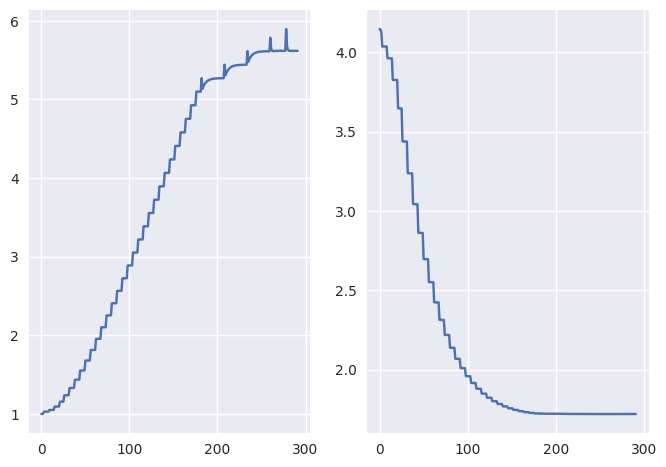

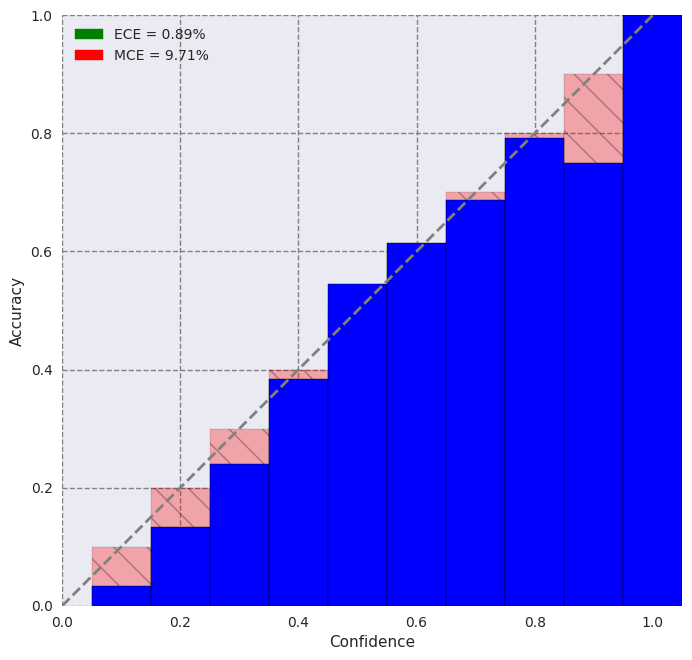

In [58]:
fed_temp = temp_scale(fed_val_scores, fed_val_targets)
draw_reliability_graph(torch.softmax(fed_test_scores / fed_temp, 1), torch.nn.functional.one_hot(fed_test_targets))
# draw_reliability_graph(torch.softmax(fed_test_scores, 1), torch.nn.functional.one_hot(fed_test_targets))

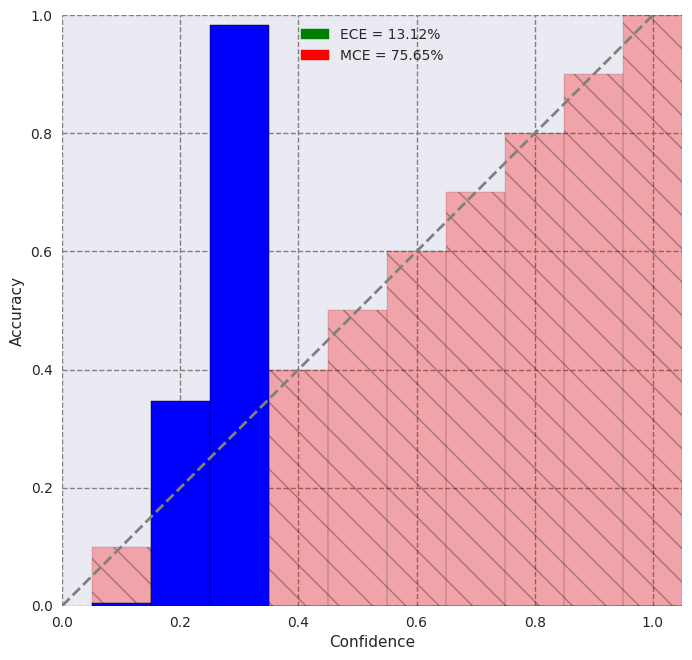

In [63]:
# tct_temp = temp_scale(tct_val_scores, tct_val_targets)
# draw_reliability_graph(torch.softmax(tct_test_scores / tct_temp, 1), torch.nn.functional.one_hot(tct_test_targets))
draw_reliability_graph(torch.softmax(tct_test_scores, 1), torch.nn.functional.one_hot(tct_test_targets))

# Conformal prediction

In [60]:
def calibrate_aps(scores, targets, alpha=0.1):
    assert scores.size(0) == targets.size(0)
    n = torch.tensor(targets.size(0))
    
    sorted_index = torch.argsort(scores, descending=True)
    sorted_scores_cumsum = torch.take_along_dim(scores, sorted_index, dim=1).cumsum(dim=1)
    score_sum_dist = torch.take_along_dim(sorted_scores_cumsum, sorted_index.argsort(1), 1)[torch.arange(n), targets]
    
    # Get the score quantile
    qhat = torch.quantile(score_sum_dist, torch.ceil((n+1)*(1-alpha))/n, interpolation='higher')
    return qhat

def inference_aps(scores, qhat):
    sorted_index = scores.argsort(1, descending=True)
    sorted_scores_cumsum = torch.take_along_dim(scores, sorted_index, dim=1).cumsum(1)
    prediction_sets = torch.take_along_dim(sorted_scores_cumsum <= qhat, sorted_index.argsort(1), 1)
    return prediction_sets

In [61]:
for val_scores, val_targets, test_scores, test_targets in [
    (cen_val_scores, cen_val_targets, cen_test_scores, cen_test_targets), 
    (fed_val_scores, fed_val_targets, fed_test_scores, fed_test_targets),
    (tct_val_scores, tct_val_targets, tct_test_scores, tct_test_targets),
]:

    temp = temp_scale(val_scores, val_targets, False)
    val_scores = torch.softmax(val_scores / temp, 1)
    test_scores = torch.softmax(test_scores / temp, 1)

    qhat = calibrate_aps(val_scores, val_targets, alpha=0.1)
    psets = inference_aps(test_scores, qhat)

    print('avg set size', psets.sum(1).float().mean())

Final T_scaling factor: 9.63
avg set size tensor(5.1630)
Final T_scaling factor: 5.62
avg set size tensor(5.8700)
Final T_scaling factor: 1.00
avg set size tensor(8.8130)
